# NN Continuous Signals

Notebook used to evaluate continuous signal data.

## Imports

In [1]:
from pathlib import Path
import os
import subprocess
from datetime import datetime
from typing import List
import pandas as pd
from copy import deepcopy
from revcan.reverse_engineering.models.experiment import Extern_Signal, Value, Experiment, Signal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from colorama import Fore, Style

import revcan.reverse_engineering.models.NNs.SignalMatchingNN_ContinuousSignals as smnn

## Set experiment

Set the experiment name and folder of the combined experiment file (containing all measurements for an experiment including ground truth values).

In [ ]:
# TODO: Set name and folder of experiment
experiment_name = "experiment_non_constant_signals"
experiment_folder = "../../data/experiments/car/speed-drive/2025-02-24_10_02_04"


Path(experiment_folder).mkdir(parents=True, exist_ok=True)
experiment_file = os.path.join(experiment_folder, f"{experiment_name}.json")
experiment = Experiment.load(experiment_file)

!python ../scripts_for_doip_new/display_experiment_metadata.py --experiment_file_path "{experiment_file}"

## Preprocessing & Training

### Data Loading

In [ ]:
# Load data
full_data = smnn.load_data(experiment)
print("full_data Shape:", full_data.shape)
print("Remaining NaN values:", full_data.isna().sum().sum())

### Split data into Train and Test set

In [ ]:
train_df, test_df = smnn.custom_train_test_split(full_data)
print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

### Preprocessing

Includes splitting the data into one data frame per signal.
This is done for the train and the test set

In [ ]:
# Expand Values of Train set
signal_data_train = smnn.split_df_by_signal(train_df)
skipped_signals_train = 0

for signal_key, df in signal_data_train.items():
    try:
        df = smnn.expand_signal_df(df)
        signal_data_train[signal_key] = df
        print(f"Signal {signal_key} → Shape: {df.shape}")
    except ValueError as e:
        skipped_signals_train += 1
        print(f"\033[91mSkipped Signal {signal_key}: {e}\033[0m")

print(f"Expanding of values of train set complete - Signals skipped: {skipped_signals_train}")

In [ ]:
# Expand Values of Test Set
signal_data_test = smnn.split_df_by_signal(test_df)
skipped_signals_test = 0

for signal_key, df in signal_data_test.items():
    try:
        df = smnn.expand_signal_df(df)
        signal_data_test[signal_key] = df
        print(f"Signal {signal_key} → Shape: {df.shape}")
    except ValueError as e:
        skipped_signals_test += 1
        print(f"\033[91mSkipped Signal {signal_key}: {e}\033[0m")

print(f"Expanding of values of test set complete - Signals skipped: {skipped_signals_test}")

## Preprocess Data & Train NN per Signal

The epochs, batch_size and hidden layers config can be set and modified individually.
Activating the check_for_ambigous_signals flag, excludes signals that have a feature overlap (same value for different ground truth categories).

In [ ]:
## NN hyperparameters
epochs = 200
batch_size = 64
hidden_layers_config = [128, 64, 32]
check_for_ambiguous_signals = True

results = {}
models = {}
for signal_key in signal_data_train:
    # Check if found test data for signal
    if signal_key not in signal_data_test:
        print(f"\033[93mSkipping {signal_key} — not in test set\033[0m")
        continue
    
    if check_for_ambiguous_signals:
        # Check whether signal has the same byte value for more then one ground_truth class
        if smnn.is_ambiguous_signal(signal_data_train[signal_key]):
            print(f"\033[93mSkipping {signal_key} — feature overlap between classes\033[0m")
            continue


    try:
        # Preprocess data
        X_train, y_train = smnn.preprocess_signal_df(signal_data_train[signal_key])
        X_test, y_test = smnn.preprocess_signal_df(signal_data_test[signal_key])

        # Check for signals with no variance
        if smnn.is_useless_signal(train_df) or smnn.is_useless_signal(test_df):
            print(f"\033[93mSkipping {signal_key} — input features have no variation\033[0m")
            continue

        # Train model
        model, metrics = smnn.train_signal_model(X_train, y_train, X_test, y_test, hidden_layers_config=hidden_layers_config, epochs=epochs,batch_size=batch_size)
        results[signal_key] = metrics
        models[signal_key] = model

        mse = metrics['mse']
        r2 = metrics['r2']

        print(f"Trained {signal_key} → MSE: {mse:.3f}, R²: {r2:.3f}")
    except Exception as e:
        print(f"\033[91mFailed {signal_key}: {e}\033[0m")

## Evaluation of Models

Displays the top performing DIDs.

In [ ]:
top_n = 50
sorted_results = sorted(results.items(), key=lambda x: x[1]['mse'])

# Header
print(f"{'Rank':<6} {'Signal':<20} {'Length':<8} {'MSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 70)

for i, (signal_key, metrics) in enumerate(sorted_results[:top_n]):
    signal_df = signal_data_train[signal_key]
    byte_columns = [col for col in signal_df.columns if col.startswith("Byte_")]
    signal_length = len(byte_columns)

    mse = metrics['mse']
    mae = metrics['mae']
    r2 = metrics['r2']
    signal_str = f"{signal_key}"

    row = f"{i+1:<6} {signal_str:<20} {signal_length:<8} {mse:<10.4f} {mae:<10.4f} {r2:<10.4f}"

    if r2 >= 0.95:
        print(Fore.GREEN + row + Style.RESET_ALL)
    else:
        print(row)



Ignore below line. Used to enable Run all.

In [ ]:
raise SystemExit("STOP")

## Validation

Display raw train and test data for a specific signal.

In [ ]:
signal_key = (16502, 2182) # Speed Drive on VCU
#signal_key = (16523, 4110)  # Vehicle Speed Paper
#signal_key = (16402, 7951) # Steering Wheel Angle Paper
#signal_key = (16395, 11030) # Speed Drive
#signal_key = (16508, 16023) # Speed Drive on correct ECU

print(f"Server: {signal_key[0]}, DID: {signal_key[1]}")
print("Training Set Data:")
signal_data_train[signal_key]

In [ ]:
print(f"Server: {signal_key[0]}, DID: {signal_key[1]}")
print("Test Set Data:")
signal_data_test[signal_key]

### Plot Data

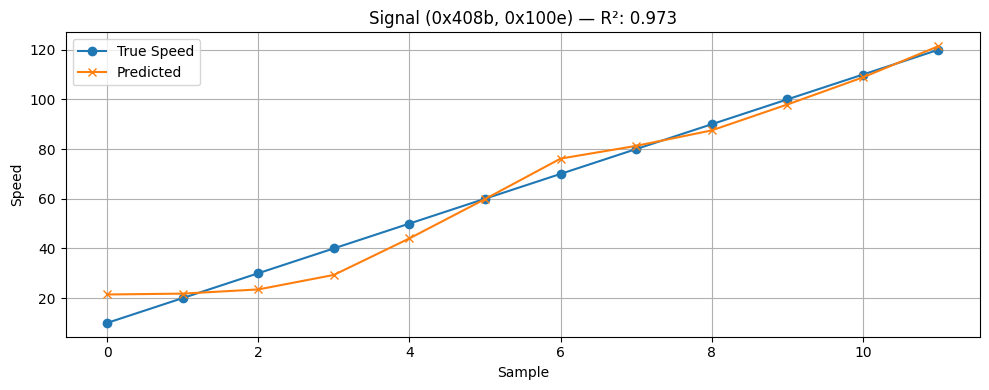

In [ ]:
import matplotlib.pyplot as plt

# Pick a signal that performed well
signal_key = (16523, 4110)
signal_key_hex_str = f"(0x{signal_key[0]:04x}, 0x{signal_key[1]:04x})"
df_train = signal_data_train[signal_key]
df_test = signal_data_test[signal_key]

# Preprocess the signal
X_train, y_train = smnn.preprocess_signal_df(df_train)
X_test, y_test = smnn.preprocess_signal_df(df_test)

# Train the model (or use your stored model if saved)
model, metrics = smnn.train_signal_model(X_train, y_train, X_test, y_test, epochs=500)

# Predict
model.eval()
with torch.no_grad():
    preds = model(X_test).squeeze().cpu().numpy()
    true = y_test.cpu().numpy()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(true, label="True Speed", marker="o")
plt.plot(preds, label="Predicted", marker="x")
plt.title(f"Signal {signal_key_hex_str} — R²: {metrics['r2']:.3f}")
plt.xlabel("Sample")
plt.ylabel("Speed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Additional Code for Debugging

Not necessary for using the notebook.

In [ ]:
print(train_df.info(), "\n")
print(test_df.info(), "\n")
print(train_df.head(30), "\n")
print(test_df.head(30))

In [ ]:
# Set a threshold for valid signal values (adjust if necessary)
MAX_VALID_VALUE = 1e6  # Anything above this is likely incorrect
MIN_VALID_VALUE = -1e6

# Find invalid data types
invalid_signals = train_df[
    (train_df["Value"] > MAX_VALID_VALUE) | (train_df["Value"] < MIN_VALID_VALUE)
][["Server_ID", "DID", "Data Type"]].drop_duplicates()

print("Dropping signals with extreme values:")
print(invalid_signals)

# Remove invalid signals from train and test sets
train_df = train_df.merge(invalid_signals, on=["Server_ID", "DID", "Data Type"], how="left", indicator=True)
train_df = train_df[train_df["_merge"] == "left_only"].drop(columns=["_merge"])

test_df = test_df.merge(invalid_signals, on=["Server_ID", "DID", "Data Type"], how="left", indicator=True)
test_df = test_df[test_df["_merge"] == "left_only"].drop(columns=["_merge"])


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
import torch

# Standardization
scaler = RobustScaler()

# Group data by (Server_ID, DID, Data Type) to train individual models
unique_signals = train_df.groupby(["Server_ID", "DID", "Data Type"])
unique_speeds_expected = len(train_df["Speed"].unique())

results = []
models = {}

for (server_id, did, dtype), group in unique_signals:
    print(f"Checking signal: Server_ID={server_id}, DID={did}, Data_Type={dtype}")

    # Drop rows with missing values
    group = group.dropna(subset=["Speed", "Value"])

    # Check if all 12 unique speeds are present
    unique_speeds = group["Speed"].nunique()
    if unique_speeds < unique_speeds_expected:
        print(f"Skipping {server_id}-{did}-{dtype}: only {unique_speeds} unique speeds")
        continue

    print(f"Training model for Server_ID={server_id}, DID={did}, Data_Type={dtype}")

    # Extract input and target
    train_X = group["Value"].values.reshape(-1, 1)
    train_y = group["Speed"].values

    # Filter and clean test data
    test_group = test_df[
        (test_df["Server_ID"] == server_id) & 
        (test_df["DID"] == did) & 
        (test_df["Data Type"] == dtype)
    ].dropna(subset=["Speed", "Value"])

    if test_group.empty:
        print(f"Skipping {server_id}-{did}-{dtype} due to missing test data")
        continue

    test_X = test_group["Value"].values.reshape(-1, 1)
    test_y = test_group["Speed"].values

    # Normalize values
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)

    # Train Model
    model = smnn.train_model(train_X, train_y, test_X, test_y, epochs=200, lr=0.0005)

    # Store trained model
    models[(server_id, did, dtype)] = model

    # Evaluate Model
    model.eval()
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
    predictions = model(test_X_tensor).detach().numpy().flatten()

    mse = mean_squared_error(test_y, predictions)
    results.append((server_id, did, dtype, mse))



# Convert results to DataFrame and find the best predictor
results_df = pd.DataFrame(results, columns=["Server_ID", "DID", "Data Type", "MSE"])
best_signal = results_df.sort_values("MSE").iloc[0]

print("\nBest Predictor:")
print(best_signal)

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Server_ID", "DID", "Data Type", "MSE"])

# Filter signals with MSE below the set treshold
threshold = 3000
filtered_signals = results_df[results_df["MSE"] < threshold]

# Print all signals that meet the threshold
if not filtered_signals.empty:
    print(f"\nFound {len(filtered_signals)} signals with MSE below {threshold}:")
    print(filtered_signals.sort_values("MSE"))
else:
    print("\nNo signals found with MSE below", threshold)

In [ ]:
import matplotlib.pyplot as plt

# Filter results for best signals
best_signals = results_df[results_df["MSE"] < threshold]

# Plot predictions vs. ground truth for each signal
plt.figure(figsize=(12, 8))

for index, row in best_signals.iterrows():
    server_id, did, dtype = row["Server_ID"], row["DID"], row["Data Type"]

    # Extract test set for this specific signal
    test_group = test_df[
        (test_df["Server_ID"] == server_id) & 
        (test_df["DID"] == did) & 
        (test_df["Data Type"] == dtype)
    ]

    if test_group.empty:
        continue

    test_X = test_group["Value"].values.reshape(-1, 1)
    test_y = test_group["Speed"].values

    # Normalize values
    scaler = StandardScaler()
    test_X = scaler.fit_transform(test_X)

    # Convert to tensor and predict
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
    predictions = models[(server_id, did, dtype)](test_X_tensor).detach().numpy().flatten()

    # Scatter plot of Ground Truth vs. Predictions
    plt.scatter(test_y, predictions, label=f"{server_id}-{did}-{dtype}", alpha=0.6)

plt.plot([0, 120], [0, 120], linestyle="--", color="red", label="Perfect Fit")  # Diagonal line
plt.xlabel("Ground Truth Speed (km/h)")
plt.ylabel("Predicted Speed (km/h)")
plt.title("Ground Truth vs. Predicted Speed for Best Signals")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import torch

# Define the target signal
TARGET_SERVER_ID = 16452
TARGET_DID = 18802
TARGET_DATA_TYPE = '<i2'

# Extract the test data for the target signal
target_test_group = test_df[
    (test_df["Server_ID"] == TARGET_SERVER_ID) &
    (test_df["DID"] == TARGET_DID) &
    (test_df["Data Type"] == TARGET_DATA_TYPE)
]

if target_test_group.empty:
    print(f"No test data found for Server_ID={TARGET_SERVER_ID}, DID={TARGET_DID}, Data Type={TARGET_DATA_TYPE}")
else:
    # Extract input values
    test_X = target_test_group["Value"].values.reshape(-1, 1)
    test_y = target_test_group["Speed"].values
    
    # Normalize input values
    test_X = scaler.transform(test_X)
    
    # Retrieve the trained model
    model = models.get((TARGET_SERVER_ID, TARGET_DID, TARGET_DATA_TYPE))
    
    if model is None:
        print(f"No trained model found for Server_ID={TARGET_SERVER_ID}, DID={TARGET_DID}, Data Type={TARGET_DATA_TYPE}")
    else:
        # Predict speeds
        model.eval()
        test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
        predictions = model(test_X_tensor).detach().numpy().flatten()
        
        # Create DataFrame to display results
        results_df = pd.DataFrame({
            "Value": target_test_group["Value"].values,
            "Ground Truth Speed": test_y,
            "Predicted Speed": predictions
        })
        
        # Display results in a tabular format
        print(results_df.head(20))  # Display the first 20 rows for quick


In [ ]:
from collections import Counter

expected_speeds = set([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
required_train_samples = 3
required_test_samples = 2

valid_signals = []

# Group by signal
grouped = train_df.groupby(["Server_ID", "DID", "Data Type"])

for signal_key, train_group in grouped:
    # Check if all expected speeds are present
    train_speeds = train_group["Speed"].value_counts()
    
    if not expected_speeds.issubset(train_speeds.index):
        continue  # skip if some speeds are missing

    # Check sample count per speed
    if not all(train_speeds[speed] == required_train_samples for speed in expected_speeds):
        continue  # skip if sample count per speed isn't exactly as expected

    # Now check the corresponding test group
    server_id, did, dtype = signal_key
    test_group = test_df[
        (test_df["Server_ID"] == server_id) &
        (test_df["DID"] == did) &
        (test_df["Data Type"] == dtype)
    ]
    test_speeds = test_group["Speed"].value_counts()

    if not expected_speeds.issubset(test_speeds.index):
        continue  # skip if some speeds missing in test

    if not all(test_speeds[speed] == required_test_samples for speed in expected_speeds):
        continue  # skip if test sample count isn't exact

    # If passed all checks, add to valid list
    valid_signals.append(signal_key)

# Output results
print(f"Found {len(valid_signals)} valid signals with full coverage and expected sample counts.")
for sig in valid_signals:
    print(f"Server_ID={sig[0]}, DID={sig[1]}, Data Type={sig[2]}")


In [ ]:
# Display the first few rows
full_data.head(30)

In [ ]:
full_data.info()

In [ ]:
nan_rows = full_data[full_data.isna().any(axis=1)]
print(nan_rows)


In [ ]:
for col in full_data.columns[4:]:  # Only apply to Value_* columns
    full_data[col] = pd.to_numeric(full_data[col], errors='coerce')
print(full_data.dtypes)

In [ ]:
print("Infinity values:", np.isinf(full_data.iloc[:, 4:]).sum().sum())

In [ ]:
print("Missing values per column:\n", full_data.isnull().sum())

In [ ]:
print(f"{len(full_data['Speed'].unique())} unique speed values:", full_data["Speed"].unique())

In [ ]:
print(f"{len(full_data['Data Type'].unique())} unique data type values:", full_data["Data Type"].unique())

In [ ]:
full_data.describe()

In [ ]:
full_data[full_data["Speed"] == 20].head()

In [ ]:
print(f"Dataset contains {full_data.shape[0]} rows and {full_data.shape[1]} columns.")